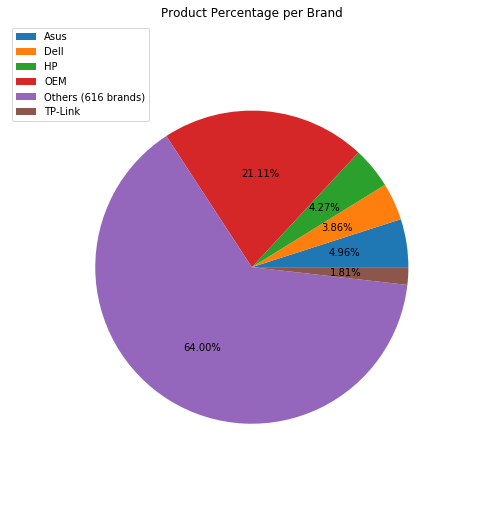

In [382]:
import psycopg2, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
import seaborn as sns
import sys
sys.path.insert(1,"e:\\projects\\machine_learning\\week_1\\data_scrapping")
from packages.object_data import category

conn = psycopg2.connect("dbname=postgres port=5433 user=postgres")

cur = conn.cursor()

categories = category.category().get_leaf_category_by_root(1846,conn)
categories = pd.DataFrame(categories, columns=['category_id', 'category_level_1'])

cur.execute("""select p.product_id, p.title, p.price, p.tiki_now, p.brand, p.detail, cpd.category_id
                from products p
                    join category_product_detail cpd
                        on p.product_id = cpd.product_id
                where cpd.category_id in %s""", (tuple(categories['category_id']),))

data = cur.fetchall()
cur.close()
conn.close()

# Transform data
data = pd.DataFrame(data, columns=["product_id","title", "price", "tiki_now", "brand", "detail","category_id"])
data = data.merge(categories, on="category_id", how="inner")

# Clean Data
data = data.drop_duplicates(subset="product_id",keep="first")
data.sort_values(by='product_id')
data['brand'] = data['brand'].replace("\t", "", regex=True)

brand_mode = data['brand'].value_counts()
top_5_brands = pd.Series(brand_mode.head(5))
others_key = 'Others (' + str(brand_mode[6:].count()) + ' brands)'
others = pd.Series({others_key:sum(brand_mode[6:])})

brand_agg = top_5_brands.add(others, fill_value = 0)

plt.figure(figsize=(9,9))
plt.pie(brand_agg, autopct='%.2f%%', radius = 0.8)
plt.legend(brand_agg.index,loc='upper left')
plt.title("Product Percentage per Brand")
plt.show()


In [392]:
# for add color bar chart purpose
unique_categories = pd.DataFrame(data['category_level_1'].drop_duplicates(keep='first').reset_index(drop=True).to_numpy(), columns=['category'])
unique_categories = unique_categories.sort_values(by='category')
category_level_1 = unique_categories.assign(color = ['#A6373F','#AAA839','#A6373F','#2D4571', '#2D4571', '#2D4571'])
# category_level_1
c_data = data
c_data = c_data.merge(category_level_1,left_on='category_level_1', right_on='category', how='left')

c:\python\python37-32\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


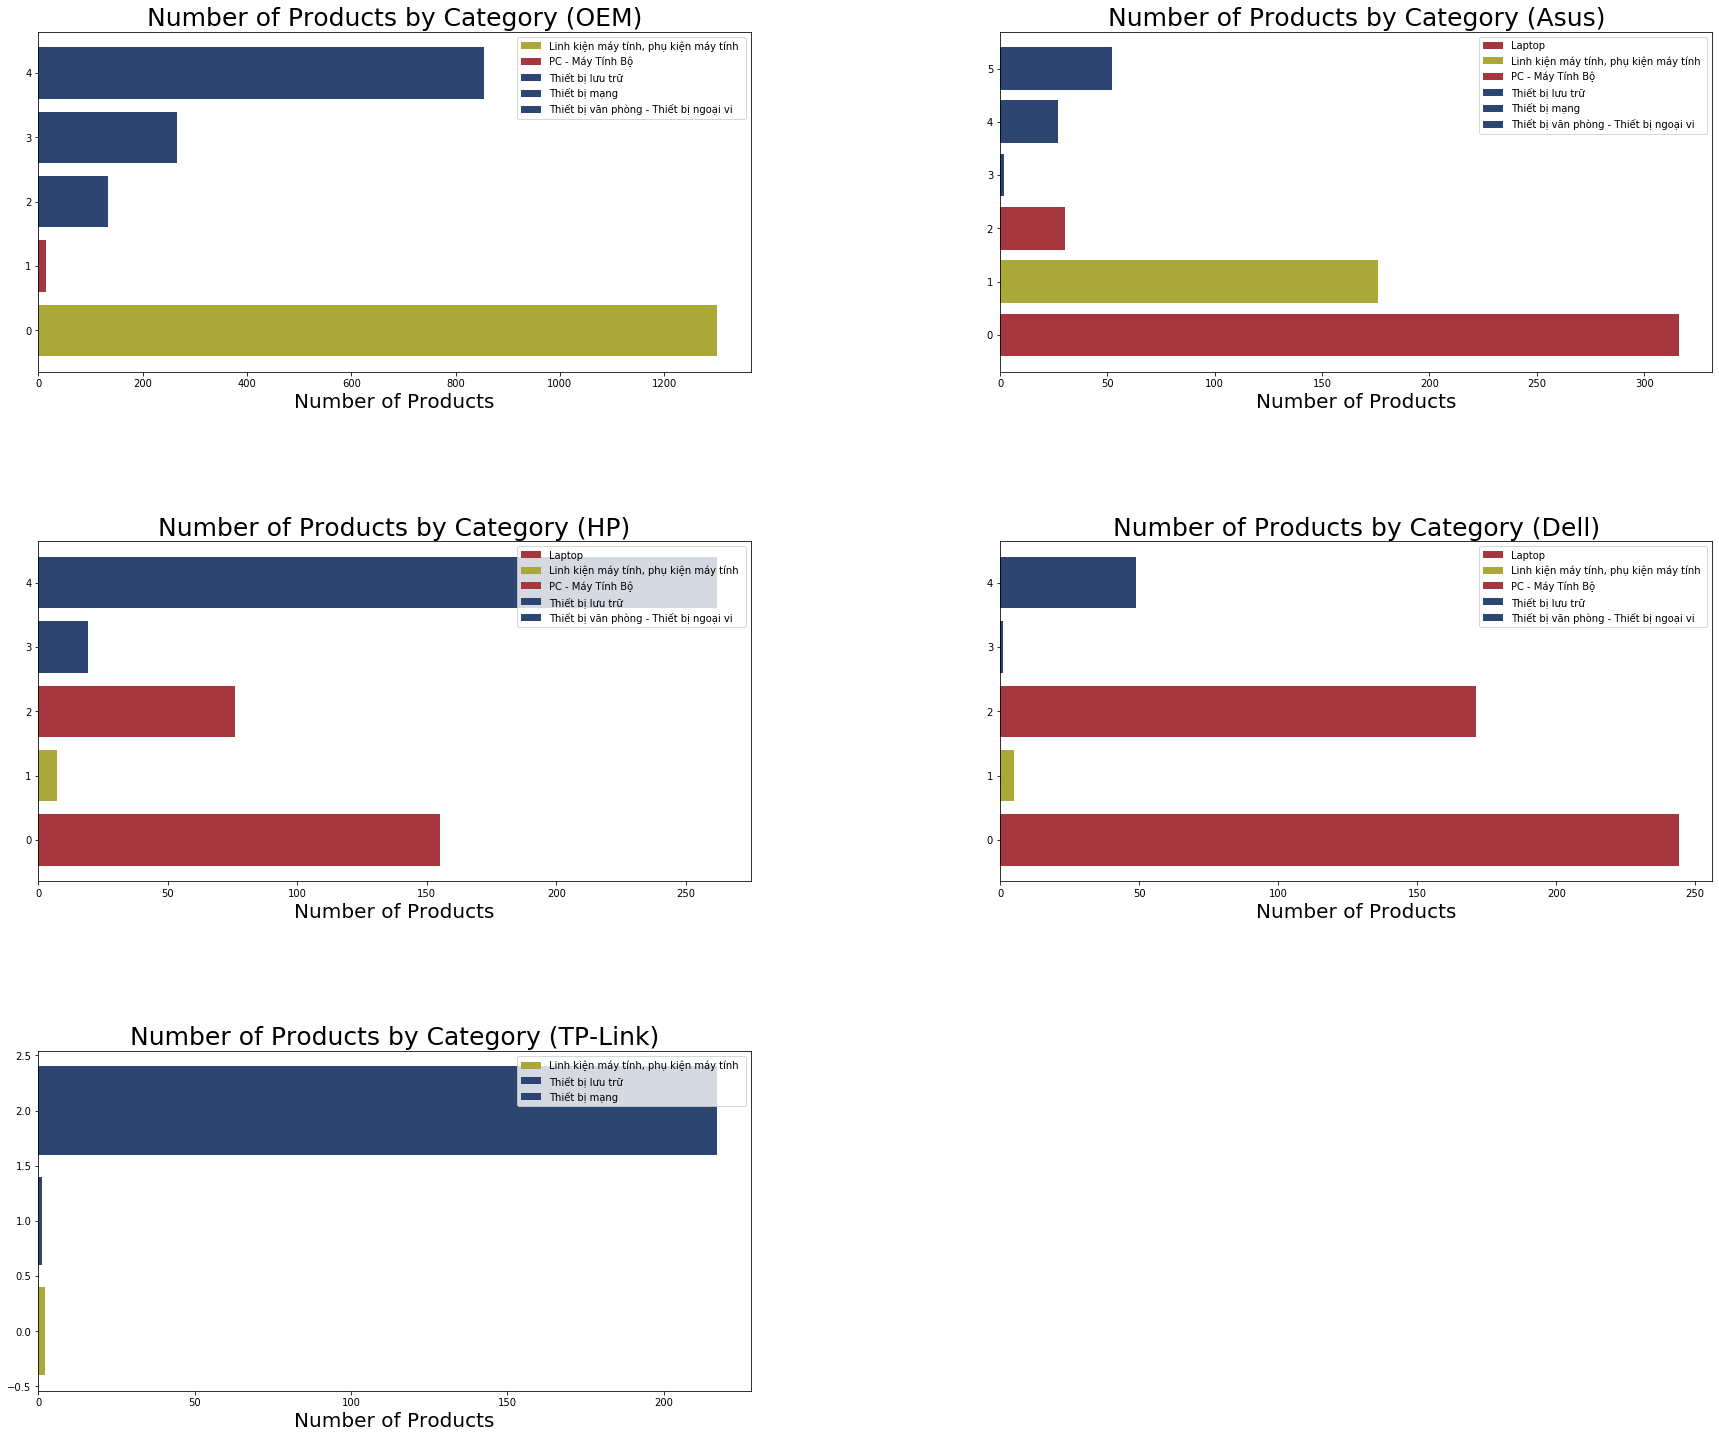

In [393]:
fig = plt.figure(figsize=(30,25))
for index_ in range(top_5_brands.count()):
    brand_name = top_5_brands.index[index_]
    brand_frequence = c_data[c_data['brand'] == brand_name].groupby(['brand','category_level_1','color']).count()['product_id']
    brand_frequence = brand_frequence.reset_index()
    brand_frequence = brand_frequence.rename({'category_level_1':'category','product_id':'counts'}, axis=1)
    
    labels = brand_frequence['category']
    amounts = brand_frequence['counts']
    color_ = brand_frequence['color']
    y_positions = range(len(labels))
    
    for index_label in y_positions:
        ax1 = plt.subplot(3,2,index_ + 1)
        plt.barh(y_positions[index_label], amounts[index_label], label = labels[index_label], color=color_[index_label])
    plt.legend(loc='upper right')
    plt.xlabel("Number of Products", fontsize=(20))
    plt.title("Number of Products by Category (" + brand_name + ")", fontsize=25)

plt.subplots_adjust(hspace=.5, wspace=.35)

In [440]:
def setcolor(field, data, color_arg):
    unique_categories = pd.DataFrame(data[field].drop_duplicates(keep='first').reset_index(drop=True).to_numpy(), columns=['category'])
    unique_categories = unique_categories.sort_values(by='category')
    color_mapping = unique_categories.assign(color = color_arg)
    return color_mapping
    
def transform_data(data, pbrand_name, color_mapping, field_mapping):
    c_data = data
    c_data = c_data.merge(color_mapping, left_on= field_mapping, right_on='category', how='left')

    brand_name = pbrand_name
    brand_frequence = c_data[c_data['brand'] == brand_name].groupby(['brand','category_level_1','color']).count()['product_id']
    brand_frequence = brand_frequence.reset_index()
    brand_frequence = brand_frequence.rename({'category_level_1':'category','product_id':'counts'}, axis=1)
    return brand_frequence
    
def brand_bar_chart(brand_frequence, labels, amounts, colors, brand_name):
    fig = plt.figure(figsize=(30,20))    
    y_positions = range(len(labels))

    for index_label in y_positions:
        ax1 = plt.subplot(3,2,index_ + 1)
        plt.barh(y_positions[index_label], amounts[index_label], label = labels[index_label], color=color_[index_label])
    plt.legend(loc='upper right')
    plt.xlabel("Number of Products", fontsize=(15))
    plt.title("Number of Products by Category (" + brand_name + ")", fontsize=20)

    plt.subplots_adjust(hspace=.5, wspace=.35)

c:\python\python37-32\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


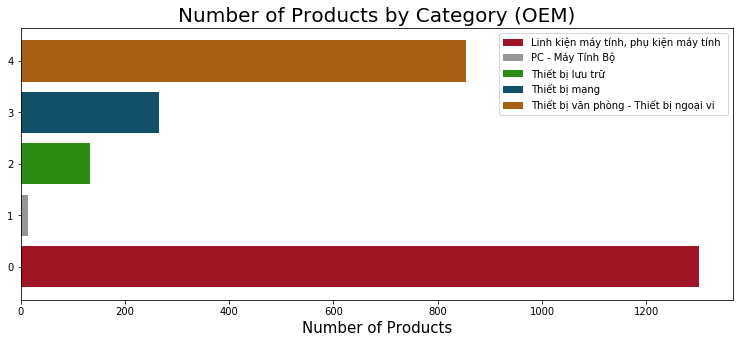

In [455]:
color_mapping = setcolor('category_level_1', data, ['#969696','#9F1525','#969696','#2C8b12', '#115068', '#A66116']) 
brand_frequence = transform_data(data, 'OEM', color_mapping, 'category_level_1')

labels = brand_frequence['category']
amounts = brand_frequence['counts']
color_ = brand_frequence['color']
brand_bar_chart(brand_frequence, labels, amounts, colors,'OEM')

c:\python\python37-32\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


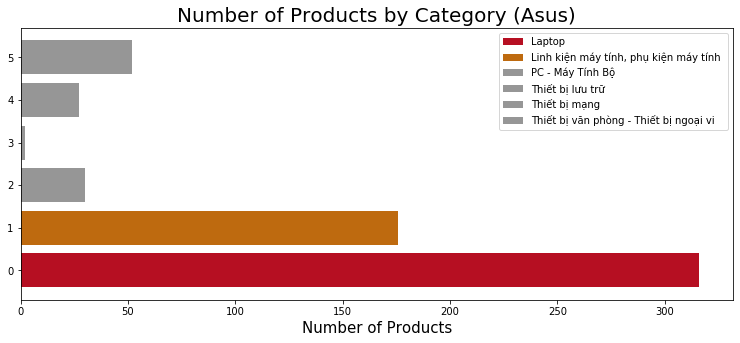

In [456]:
color_mapping = setcolor('category_level_1', data, ['#B60F22','#BE6A0F','#969696','#969696', '#969696', '#969696']) 
brand_frequence = transform_data(data, 'Asus', color_mapping, 'category_level_1')

labels = brand_frequence['category']
amounts = brand_frequence['counts']
color_ = brand_frequence['color']
brand_bar_chart(brand_frequence, labels, amounts, colors, 'Asus')

c:\python\python37-32\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


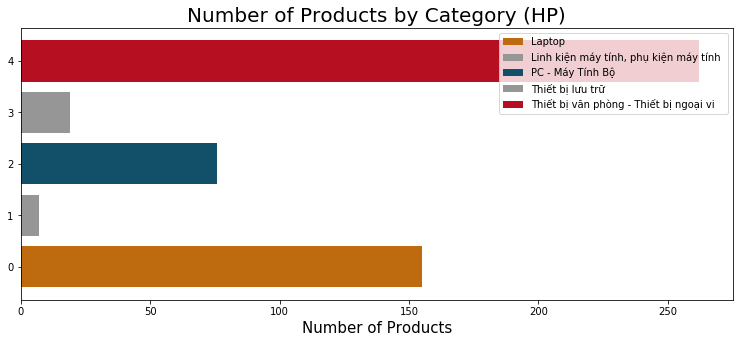

In [457]:
color_mapping = setcolor('category_level_1', data, ['#BE6A0F','#969696','#115068','#969696', '#2CA00D', '#B60F22']) 
brand_frequence = transform_data(data, 'HP', color_mapping, 'category_level_1')

labels = brand_frequence['category']
amounts = brand_frequence['counts']
color_ = brand_frequence['color']
brand_bar_chart(brand_frequence, labels, amounts, colors, 'HP')

c:\python\python37-32\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


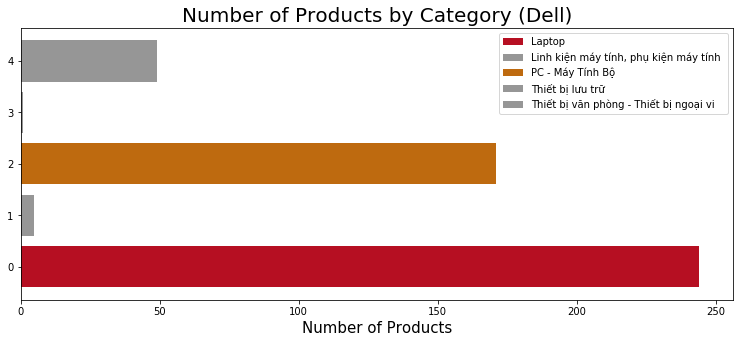

In [450]:
color_mapping = setcolor('category_level_1', data, ['#B60F22','#969696','#BE6A0F','#969696', '#969696', '#969696']) 
brand_frequence = transform_data(data, 'Dell', color_mapping, 'category_level_1')

labels = brand_frequence['category']
amounts = brand_frequence['counts']
color_ = brand_frequence['color']
brand_bar_chart(brand_frequence, labels, amounts, colors,'Dell')

c:\python\python37-32\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


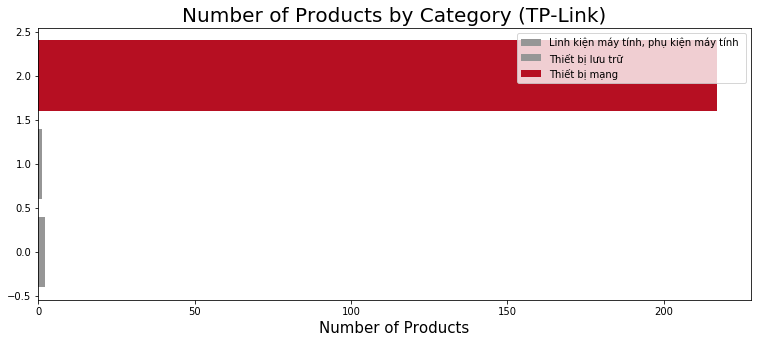

In [451]:
color_mapping = setcolor('category_level_1', data, ['#B60F22','#969696','#BE6A0F','#969696', '#B60F22', '#969696']) 
brand_frequence = transform_data(data, 'TP-Link', color_mapping, 'category_level_1')

labels = brand_frequence['category']
amounts = brand_frequence['counts']
color_ = brand_frequence['color']
brand_bar_chart(brand_frequence, labels, amounts, colors,'TP-Link')

In [381]:
## achired

# transfrom dict to table
object_ = 'thuong_hieu'
data.detail.apply(lambda x: x[object_] if object_ in list(x) else "")

# send dynamic key to each row?
data['keys'] = data.detail.apply(lambda x: list(x))
data.index[1]
pd.DataFrame.from_dict(data.detail[0], orient='index')

# transform dict to dataframe
has_detail = data.detail.apply(lambda x: len(list(x)) > 0)
df_detail = list(data.detail[has_detail])
df_detail = pd.DataFrame(df_detail)
df_detail.columns
data[~(has_detail)]

TypeError: 'NoneType' object is not iterable